## Preprocess Dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
train_test_ratio = 0.1
train_valid_ratio = 0.8

In [ ]:
first_n_words = 200

In [ ]:
def trim_string(raw:str, first_n_words=200):
    """This is the function for truncate the input sentence.

    Args:
        raw (str): input sentence
        first_n_words (int): the length of output sentence.

    Returns:
        output (str): the string after be truncated.
    """
    raw = raw.split(maxsplit=first_n_words)
    output = ' '.join(raw[:first_n_words])
    return output

In [ ]:
df_raw = pd.read_csv(filepath_or_buffer="news.csv")
df_raw.head()

In [ ]:
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw["text"]
df_raw = df_raw.reindex(columns=["label", 'title', 'text', 'titletext'])
df_raw.head()

In [ ]:
df_raw.drop(df_raw[df_raw.text.str.len() < 5].index, inplace=True, axis='index')
df_raw.head()

In [ ]:
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

In [ ]:
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

In [ ]:
# train, test split
df_real_train_full, df_real_test = train_test_split(df_real, test_size=train_test_ratio, random_state=1)
df_fake_train_full, df_fake_test = train_test_split(df_fake, test_size=train_test_ratio, random_state=1)

In [ ]:
# train, valid split
df_real_train, df_real_valid = train_test_split(df_real_train_full, test_size=train_valid_ratio, random_state=1)
df_fake_train, df_fake_valid = train_test_split(df_fake_train_full, test_size=train_valid_ratio, random_state=1)

In [ ]:
df_train = pd.concat(objs=[df_real_train, df_fake_train], ignore_index=True, sort=False)
df_test = pd.concat(objs=[df_real_test, df_fake_test], ignore_index=True, sort=False)
df_valid = pd.concat(objs=[df_real_valid, df_fake_valid], ignore_index=True, sort=False)

In [ ]:
import os

os.makedirs(name='data', exist_ok=True)
df_train.to_csv('data/train.csv', index=False)
df_test.to_csv('data/test.csv', index=False)
df_valid.to_csv('data/valid.csv', index=False)

In [ ]:
df_train.head()

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/home/huy/anaconda3/envs/nlp/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
from loguru import logger

## Step 3: Load Dataset

In [4]:
class NewsDataset(Dataset):
    """Initialize

    Args:
        df (pd.DataFrame): train or test or valid dataframe.
    """
    def __init__(self, df:pd.DataFrame):
        self.labels = df['label'].values
        self.texts = df['titletext'].values
        
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, index):
        return self.labels[index]
    
    def get_batch_texts(self, index):
        return self.texts[index]
    
    def __getitem__(self, index):
        batch_texts = self.get_batch_texts(index)
        batch_labels = self.get_batch_labels(index)
        
        return batch_labels, batch_texts

In [5]:
train_df = pd.read_csv('data/train.csv')
train_df['text_len'] = train_df.apply(lambda x:len(x.text), axis=1)
train_df = train_df.sort_values(by="text_len")

In [6]:
train_dataset = NewsDataset(train_df)

In [7]:
valid_df = pd.read_csv('data/valid.csv')
valid_df['text_len'] = valid_df.apply(lambda x:len(x.text), axis=1)
valid_df = valid_df.sort_values(by="text_len")

In [8]:
valid_dataset = NewsDataset(valid_df)

In [9]:
tokenizer = get_tokenizer(tokenizer="basic_english")

In [16]:
def yield_tokens(data_iter, tokenizer):
    for text in data_iter:
        yield tokenizer(text)

In [17]:
vocab = build_vocab_from_iterator(
    yield_tokens(iter(train_df.titletext), tokenizer=tokenizer), 
    specials=["<pad>", "<unk>"],
    min_freq=3,
)

In [18]:
# token <unk> will be returned
# if OOV token is queried
vocab.set_default_index(vocab["<unk>"])

OOV token is <font color='green'>**Out of Vocabulary**</font> token

In [19]:
text_pipeline = lambda x: vocab(tokenizer(x))

In [20]:
def collate_fn(batch):
    label_list, text_list, text_len = [], [], []
    
    for (label_, text_) in batch:
        label_list.append(label_)
        preprocessed_text = text_pipeline(text_)
        text_list.append(torch.LongTensor(preprocessed_text))
        text_len.append(len(preprocessed_text))
    
    padded_sequences = pad_sequence(sequences=text_list, padding_value=vocab["<pad>"], batch_first=True)
    
    return torch.Tensor(label_list), padded_sequences, text_len

In [21]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [22]:
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [23]:
vocab_size = len(vocab)
vocab_size

7153

In [24]:
for d in train_loader:
    print(d)
    break

(tensor([1., 0., 0., 1., 0., 0., 0., 0.]), tensor([[ 583,  247,    1,  602,   12,    7,    1,    5,  174,  124,    3,   49,
          834,    3,    3,  415, 1536,    1,    4,   55,   19,    1,    1,    0],
        [3004, 6445,  279,   22,   14,  798,    8, 3643,    6, 2007,   14,    3,
         1931,  132,   55,  137,  166,  141,  714, 3004,  205,  108,  169,  118],
        [5749,   14,   15, 6022,    1,  218,  333, 1084,    3,    2,  997,  294,
         4943, 2353,   17,   28,   57, 1388,    3,    0,    0,    0,    0,    0],
        [ 213,    1, 5385, 4506, 1023,   16,  553, 1622,    3,  213,    1, 5385,
         4506, 1023,   16,  553, 1622,    0,    0,    0,    0,    0,    0,    0],
        [ 924,   14,   15,    1, 2357,  169,    3,    2,    1,  552,    5,  533,
           79,   23,   11, 3626, 1611,    3,    0,    0,    0,    0,    0,    0],
        [  29, 3390,    5, 2018,  162,    1,   13,  203, 2005,    3,    7, 3426,
            9, 1417,   91,   27, 1632, 1434,   12, 2133, 3385

## Step 4: Build Model

In [25]:
class RealFakeDetection(nn.Module):
    
    def __init__(self, dimension=128, max_features=vocab_size):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=max_features, embedding_dim=300)
        self.dimension = dimension
        self.lstm = nn.LSTM(
            input_size=300,
            hidden_size=dimension,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        self.drop = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(
            in_features=2*dimension,
            out_features=1
        )
    
    def forward(self, text, text_len):
        text_emb = self.embedding(text)
        
        packed_input = pack_padded_sequence(
            input=text_emb, 
            lengths=text_len,
            batch_first=True,
            enforce_sorted=False
        )
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(
            sequence=packed_output,
            batch_first=True
        )
        
        # for getting the final dept-wise and time-wise
        out_forward = output[:, max(text_len) - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat(tensors=(out_forward, out_reverse),
                                dim=1)
        # current shape is: (batch_size, 2*self.dimension)
        text_fea = self.drop(out_reduced)
        # -> shape: (batch_size, 1)
        # because fully connected layer have out_features is `1`
        text_fea = self.fc(text_fea)
        
        # squeeze with dim=1 will return flatten tensor.
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)
        
        return text_out

## Step 5: Training

In [26]:
def save_checkpoint(save_path, model:RealFakeDetection, optimizer:optim.Optimizer, valid_loss):
    
    if save_path == None:
        logger.warning("save_path is None. So save_path is set to ==> 'models/lstm.pt'")
        os.makedirs("models/", exist_ok=True)
        save_path = "models/lstm.pt"
    
    folder_path = os.path.split(save_path)[0]
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path,)
    
    state_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'valid_loss': valid_loss
    }
    
    torch.save(obj=state_dict, f=save_path)
    logger.info(f"Model saved to ==> {save_path}")

In [27]:
def load_checkpoint(load_path, model:RealFakeDetection, optimizer:optim.Optimizer, device):
    if load_path == None:
        logger.warning("load_path is None. So load_path is set to 'models/lstm.pt'")
        load_path = "models/lstm.pt"
    
    state_dict = torch.load(
        f=load_path,
        map_location=device
    )
    logger.info(f"Model loaded from <== {load_path}")
    
    model.load_state_dict(state_dict=state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict=state_dict['optimizer'])
    
    return state_dict['valid_loss']

In [28]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    
    if save_path is None:
        os.makedirs(name="metrics", exist_ok=True)
        save_path = "metrics/loss.list"
        logger.warning(f"save_path is None. So save_path is set to '{save_path}'")
    
    state_dict = {
        'train_loss_list': train_loss_list,
        'valid_loss_list': valid_loss_list,
        'global_steps_list': global_steps_list
    }
    
    torch.save(obj=state_dict, f=save_path)
    logger.info(f"Model saved to ==> {save_path}")

In [29]:
def load_metrics(load_path, device):
    if load_path == None:
        load_path = "metrics/loss.list"
        logger.warning(f"load_path is None. So load_path is set to '{load_path}'")
    
    state_dict = torch.load(f=load_path, map_location=device)
    logger.info(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

For checkpoints, the model parameters and optimizer are saved; <br>
<font color="green">**$\to$ for metrics, the train loss, valid loss, and global steps are saved so diagrams can be easily reconstructed later.**</font>

In [30]:
def train(
    model:RealFakeDetection,
    optimizer:optim.Optimizer,
    device,
    criterion=nn.BCELoss(),
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=5,
    eval_every=len(train_loader) // 2,
    file_path="models",
    best_valid_loss=float("Inf")
):
    
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    logger.info("================== Start training ==================")
    model.train()
    for epoch in range(num_epochs):
        for (labels, titletext, titletext_len) in train_loader:
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len
            output = model(
                text=titletext,
                text_len=titletext_len
            )
            
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # update running values
            running_loss += loss.item()
            global_step += 1 
            
            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                
                with torch.no_grad():
                    # validation loop
                    for (labels, titletext, titletext_len) in valid_loader:
                        labels = labels.to(device)
                        titletext = titletext.to(device)
                        titletext_len = titletext_len
                        output = model(titletext, titletext_len)
                        
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()
                
                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                
                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                
                # print progress
                logger.info(
                    'Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'\
                        .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader), average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_train_loss
                    save_checkpoint(
                        save_path=file_path + "/model.pt",
                        model=model,
                        optimizer=optimizer,
                        valid_loss=best_valid_loss
                    )
                    save_metrics(
                        valid_loss_list=valid_loss_list,
                        global_steps_list=global_steps_list,
                        save_path=file_path + "/metrics.pt",
                        train_loss_list=train_loss_list
                    )
    save_metrics(
        valid_loss_list=valid_loss_list,
        global_steps_list=global_steps_list,
        save_path=file_path + "/metrics.pt",
        train_loss_list=train_loss_list
    )
    logger.info("Finished Training!")

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
model = RealFakeDetection(dimension=128, max_features=vocab_size).to(device=device)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
train(
    model=model,
    optimizer=optimizer,
    num_epochs=100,
    device=device
)

2022-12-01 10:26:15.250 | INFO     | __main__:train:21 - ================== Start training ==================
2022-12-01 10:26:18.472 | INFO     | __main__:train:72 - Epoch [1/100], Step [71/14200], Train Loss: 0.0009, Valid Loss: 0.8094
2022-12-01 10:26:18.523 | INFO     | __main__:save_checkpoint:20 - Model saved to ==> modelst/model.pt
2022-12-01 10:26:18.524 | INFO     | __main__:save_metrics:15 - Model saved to ==> modelst/metrics.pt
2022-12-01 10:26:21.802 | INFO     | __main__:train:72 - Epoch [1/100], Step [142/14200], Train Loss: 0.0005, Valid Loss: 0.8227
2022-12-01 10:26:25.024 | INFO     | __main__:train:72 - Epoch [2/100], Step [213/14200], Train Loss: 0.0006, Valid Loss: 0.8418
2022-12-01 10:26:28.351 | INFO     | __main__:train:72 - Epoch [2/100], Step [284/14200], Train Loss: 0.0005, Valid Loss: 0.8509
2022-12-01 10:26:31.479 | INFO     | __main__:train:72 - Epoch [3/100], Step [355/14200], Train Loss: 0.0005, Valid Loss: 0.8688
2022-12-01 10:26:34.723 | INFO     | __ma

2022-12-01 10:46:57.253 | INFO     | __main__:load_metrics:7 - Model loaded from <== models/metrics.pt


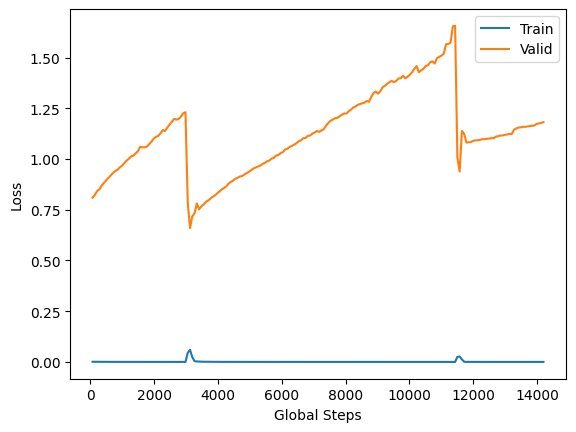

In [37]:
destination_folder = "models"

train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt', device=device)
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Coclusion
Like you have seen in the graph above, our model is <font color="red">overfitting</font> in training dataset.<br>
Solution: [link](https://stats.stackexchange.com/questions/204745/preventing-overfitting-of-lstm-on-small-dataset)

## Step 6: Evaluation

In [39]:
test_df = pd.read_csv(
    filepath_or_buffer="data/test.csv",
)
test_df['text_len'] = test_df['text'].apply(lambda x: len(x))
test_df = test_df.sort_values(by="text_len")

In [40]:
test_dataset = NewsDataset(df=test_df)

In [41]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    collate_fn=collate_fn
)

2022-12-01 10:51:54.366 | INFO     | __main__:load_checkpoint:10 - Model loaded from <== models/model.pt


Classification Report:
              precision    recall  f1-score   support

           1     0.8094    0.8275    0.8183       313
           0     0.8264    0.8082    0.8172       318

    accuracy                         0.8177       631
   macro avg     0.8179    0.8178    0.8177       631
weighted avg     0.8179    0.8177    0.8177       631



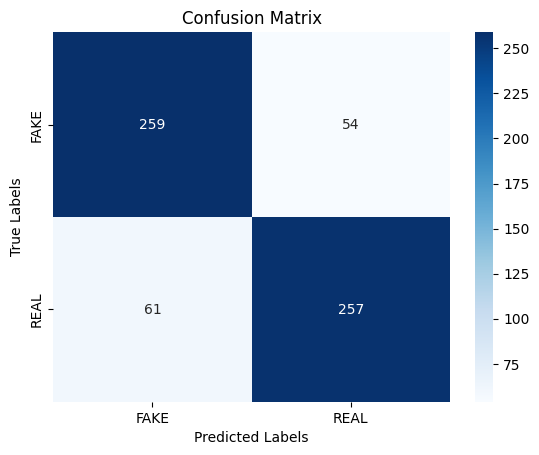

In [44]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for labels, titletext, titletext_len in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = RealFakeDetection().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer, device=device)
evaluate(best_model, test_loader)

## Test

In [ ]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence

In [ ]:
data = torch.Tensor([[1, 0, 0], [3, 4, 0], [5, 6, 0], [6, 7, 8]])
data

In [ ]:
data.shape

In [ ]:
pack_padded_sequence(
    input=data,
    lengths=[1, 2, 2, 3],
    batch_first=True,
    enforce_sorted=False
)

In [ ]:
output = torch.Tensor(
    [[[1, 2, 3, 4], 
      [4, 5, 6, 7]], 
     [[7, 8, 9, 10], 
      [10, 11, 12, 13]]]
)

In [ ]:
output.shape

`torch.Size([2, 2, 3])` is our shape with:
- `2` is our batch size.
- `2` is our sequence length.
- `4` is our embedding size.

In [ ]:
output

output from LSTM layer has shape of `torch.Size([2, 2, 12])` with:
- `2` is batch size.
- `2` is sequence length.
- `12` is hidden size (it is `2x` cause we use Bidirectional LSTM)

In [ ]:
out_forward = output[range(len(output)), 2 - 1, :2]
out_forward

In [ ]:
out_forward.shape

In [ ]:
out_reverse = output[:, 0, 2:]
out_reverse

In [ ]:
out_reverse.shape

In [ ]:
out_reduced = torch.cat((out_forward, out_reverse), dim=1)

In [ ]:
out_reduced.shape

In [ ]:
out_reduced

In [ ]:
fc = nn.Linear(
        in_features=2*2,
        out_features=1)

In [ ]:
text_fea = fc(out_reduced)
text_fea.shape

In [ ]:
text_fea

In [ ]:
text_fea.squeeze(dim=1)